---


# **Analysis of Categorical Variable Encoding Techniques**
##**Vincent Stevens - Machine Learning, Spring 2022 - Final Project**
---

In [ ]:
"""
Analysis of Categorical Variable Techniques using Logistic Regression
Copyright (C) 2022  Vincent Stevens

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

### **Overview and Objective**
For my semester 
project, I decided to focus on an area of machine learning that sparked my interest -- how to best quantify categorical variables in a dataset for ingestion by a binary classification model, specifically a logistic regression model that utilizes stochastic gradient descent and regularization. With the findings of this final project, and in conjunction with research done by three other teams, I was able to quantify the tradeoffs between running time and accuracy for many different categorical variable encoding techniques, namely ordinal, one-hot, sum, backward difference, binary, polynomial, helmert, and hashing.

The data set used is the popular US Census data set that contains information about citizens, included whether or not they make more than $50,000 a year. The total size of the dataset was 45222 entries after entries with empty feature values were dropped. Each feature space consisted of 10 different sets of categorical variables. A training set of 30162 and a test set of size 15060 were decided on. The model was run for 1000 epochs, with early termination if 5 iterations without change in result were detected. 

For each of the encoding techniques, a new model was created, the data set was re-loaded, split, then encoded, then the model was run. The time to encode and execute, along with the final accuracy, was recorded. This process was repeated 10 times for each encoding strategy. 

I will walk you through how to generate the outcome I found in my final report.
 

### **Mounting the Data Set**
The first step is to mount the Census data set. In the file downloaded from GitHub there should have been two data sets, adult_raw.test and adult_raw.train. Ensure both of those are in the same directory as this project, or modify the code below to navigate to that path.


In [22]:
from google.colab import drive
drive.mount('/content/drive')

import csv

census_fields = ['age', 'workclass', 'fnlwgt', 'education', 'education num', 
                  'marital status', 'occupation', 'relationship', 'race', 
                  'sex', 'capital gain', 'capital loss', 'hours per week', 
                  'native country', 'income']

#set test to true for the test data set because of differences in formatting
def load_census_csv(filename, test=False):
    data = []
    drop = False
    total_count = 0
    with open(filename) as csvfile:
      reader = csv.DictReader(csvfile, fieldnames=census_fields, restval='?')
      lines = list(reader)
      if test==True:
        del lines[0]
      for line in lines:
        vals = list(line.values())
        # drop if any values are missing
        if (vals.count(' ?') > 0):
          drop = True
        if drop == False:
          #trim the columns we don't need
          del line['fnlwgt']
          del line['education num']
          del line['capital gain']
          del line['capital loss']
          data.append(line)
          total_count += 1
        drop = False           

    return data, total_count

# pass in the path to the training data and the path to the test data
# returns two ordered dicts, one with the training data and one with the test
# data, both for the US Census Data
def load_census_train_and_test_data(train_data_file_path, test_data_file_path, stats=False):
  train, train_len = load_census_csv(train_data_file_path)
  test, test_len = load_census_csv(test_data_file_path, test=True)
  if (stats):
    print(' Total number of entries in the Census training set: ', train_len)
    print(' Total number of entries in the Census test set: ', test_len)
    print(' Total length of the Census data set: ', train_len+test_len)
    print(' Dropped rows with missing entries from both data sets.')
  return train, test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
####--------- Modify to your path ---------####
project_path = 'Colab Notebooks/project' #modify your project path here
####--------- Modify to your path ---------####
sys_path = prefix + project_path
sys.path.append(sys_path)

fp_data = os.path.join(sys_path, 'adult_raw.train')
fp_test = os.path.join(sys_path, 'adult_raw.test')


### **Installing the required dependencies**


In [24]:
!pip install category_encoders
from numpy.core.arrayprint import format_float_scientific
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
import pandas as pd
import matplotlib.pyplot as plt
import time

### **Supporting functions**


In [25]:
def convert_data(train, test):
  train_X = []
  train_y = []
  test_X = []
  test_y = []
  all_X = []
  all_y = []
  categories = []
  label_name = 'income'
  # first, get the data into the correct format
  for row in train:
    train_y.append(row[label_name])
    all_y.append(row[label_name])
    del row[label_name]
    train_X.append(list(row.values()))
    all_X.append(list(row.values()))
  for row in test:
    test_y.append(row[label_name])
    all_y.append(row[label_name])
    del row[label_name]
    test_X.append(list(row.values()))
    all_X.append(list(row.values()))
  return train_X, train_y, test_X, test_y, all_X, all_y

In [26]:
def accuracy(data, pred):
  correct = 0
  for actual, pred in zip(data, pred):
    if (actual == ' >50K.') and (pred == ' >50K'):
      correct += 1
    elif (actual == ' <=50K.') and (pred == ' <=50K'):
      correct += 1
  return float(correct)/len(data)

In [27]:
# returns the time spent encoding, None if invalid encoding scheme
# stores the correct encodings in the above lists
# can call run_model and it will use this encoding
# if a different coding is desired, must encode_data again
def encode_data(encoder='sk_onehot'):
  start_time = 0
  census_train_data, census_test_data = load_census_train_and_test_data(fp_data, fp_test)
  start_time = time.time()
  train_X, train_y, test_X, test_y, all_X, all_y = convert_data(census_train_data, census_test_data)

  e = None
  if (encoder == 'sk_onehot'):
    e = OneHotEncoder()
  elif (encoder == 'ordinal'):
    e = ce.OrdinalEncoder(return_df=False)
  elif (encoder == 'onehot'):
    e = ce.OneHotEncoder(return_df=False)
  elif (encoder == 'sum'):
    e = ce.SumEncoder(return_df=False)
  elif (encoder == 'backward_difference'):
    e = ce.BackwardDifferenceEncoder(return_df=False)
  elif (encoder == 'binary'):
    e = ce.BinaryEncoder(return_df=False)
  elif (encoder == 'hashing'):
    e = ce.HashingEncoder(return_df=False)
  elif (encoder == 'polynomial'):
    e = ce.PolynomialEncoder(return_df=False)
  elif (encoder == 'helmert'):
    e = ce.HelmertEncoder(return_df=False)
  else:
    return None

  # start the timer
  time_start = time.time()
  e.fit(all_X)
  train_X = e.transform(train_X)
  test_X = e.transform(test_X)
  # ordinal encode target variable
  label_encoder = LabelEncoder()
  label_encoder.fit(all_y)
  y_train = label_encoder.transform(train_y)
  y_test = label_encoder.transform(test_y)
  end_time = time.time()
  return (end_time - start_time), train_X, train_y, test_X, test_y

In [31]:
# returns the accuracy and length of time
def run_model(train_X, train_y, test_X, test_y, epochs=1000, random_state=1):
    # done encoding, run the model
    # define the model
    start_time = time.time()
    model = SGDClassifier(loss='log', max_iter=epochs, random_state=random_state)
    # fit on the training set
    model.fit(train_X, train_y)
    # predict on test set
    yhat = model.predict(test_X)
    acc = 0
    # evaluate predictions
    acc = accuracy(test_y, yhat)
    end_time = time.time()
    return acc, (end_time-start_time)

### **Running the model on the census data**

In [47]:
def main_census(num_cycles):
  print("Logistic Regression Model utilizing Stochastic Gradient Descent and various categorical variable encoding techniques")
  print(" 1000 epochs each run with early termination after 5 epochs if no change in accuracy")
  print("Census Data Set:")
  load_census_train_and_test_data(fp_data, fp_test, stats=True)
  options = ['ordinal', 'onehot', 'sum', 'backward_difference', 'binary', 'polynomial', 'helmert', 'hashing']
  columns = ['encoding time', 'execution time', 'accuracy']
  vals = []
  accuracies = [[0]*num_cycles for i in range(len(options))]
  enc_times = [[0]*num_cycles for i in range(len(options))]
  ex_times = [[0]*num_cycles for i in range(len(options))]
  
  # for each encoding technique, encode and run the SGD LR model on the census data
  for i in range(len(options)):
    print("Running the model %d times with %s encoding" %(num_cycles, options[i]))
    sum_enctim = 0
    sum_acc = 0
    sum_tim = 0
    runs = 0
    for j in range(0,num_cycles):
      time, trX, trY, tX, tY = encode_data(encoder=options[i])
      sum_enctim += time
      acc, tim = run_model(trX, trY, tX, tY, random_state=j)
      sum_acc += acc
      sum_tim += tim
      accuracies[i][j] = acc
      enc_times[i][j] = time
      ex_times[i][j] = tim
      runs +=1
    print("   Average encoding time: %.2f seconds" %(sum_enctim/runs))
    print("   Average accuracy: %.3f" %(sum_acc/runs))
    print("   Average execution time: %.2f seconds" %(sum_tim/runs))
    vals.append(options[i])
    avg_enctim = sum_enctim/runs
    avg_exectime = sum_tim/runs
    avg_acc = sum_acc/runs
    vals.append([avg_enctim, avg_exectime, avg_acc])

  # create the pandas data frame
  it = iter(vals)
  res_dct = dict(zip(it, it))
  df = pd.DataFrame(data=res_dct, index=columns)
  df = df.round(decimals=3)
  print("-------------- Experiment Results --------------")
  print(df.T)

  # print the graphs
  if (num_cycles > 1):
    # accuracies graph
    ylabel=''
    title=''
    for i in range(0,6):
      x = [i for i in range(1,num_cycles+1)]
      if (i==0):
        ylabel='Encoding Time (seconds)'
        title='Encoding Time per Run'
        for j in range(len(options)):
          plt.plot(x, enc_times[j], label = options[j])
      elif (i==1):
        ylabel='Encoding Time (seconds)'
        title='Encoding Time per Run Without Outliers'
        # removing hashing (j == 7)
        for j in range(len(options)):
          if (j != 7):
            plt.plot(x, enc_times[j], label = options[j])
      elif (i==2):
        ylabel='Execution Time (seconds)'
        title='Execution Time per Run'
        for j in range(len(options)):
          plt.plot(x, ex_times[j], label = options[j])
      elif (i==3):
        ylabel='Execution Time (seconds)'
        title='Execution Time per Run Without Outliers'
        # removing helmert (j == 6)
        for j in range(len(options)):
          if (j != 6):
            plt.plot(x, ex_times[j], label = options[j])
      elif (i==4):
        # accuracy
        ylabel='Accuracy'
        title='Accuracy per Run'
        for j in range(len(options)):
          plt.plot(x, accuracies[j], label = options[j])
      elif (i==5):
        # accuracy without outliers
        ylabel='Accuracy'
        title='Accuracy per Run Without Outliers'
        # removing ordinal (j == 0) and hashing (j == 7)
        for j in range(len(options)):
          if ((j != 0) and (j != 7)):
            plt.plot(x, accuracies[j], label = options[j])

      plt.legend()
      plt.xticks(x)
      plt.ylabel(ylabel)
      plt.xlabel('Run Number')
      plt.title(title)
      plt.show()


### **Main function, enter the number of runs desired here. Recommend 2-20 for best time performance**


Logistic Regression Model utilizing Stochastic Gradient Descent and various categorical variable encoding techniques
 1000 epochs each run with early termination after 5 epochs if no change in accuracy
Census Data Set:
 Total number of entries in the Census training set:  30162
 Total number of entries in the Census test set:  15060
 Total length of the Census data set:  45222
 Dropped rows with missing entries from both data sets.
Running the model 10 times with ordinal encoding
   Average encoding time: 1.33 seconds
   Average accuracy: 0.698
   Average execution time: 0.88 seconds
Running the model 10 times with onehot encoding
   Average encoding time: 2.50 seconds
   Average accuracy: 0.832
   Average execution time: 0.72 seconds
Running the model 10 times with sum encoding
   Average encoding time: 2.52 seconds
   Average accuracy: 0.831
   Average execution time: 0.74 seconds
Running the model 10 times with backward_difference encoding
   Average encoding time: 2.47 seconds
   A

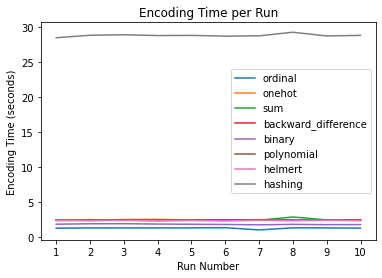

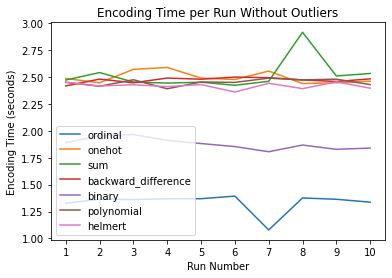

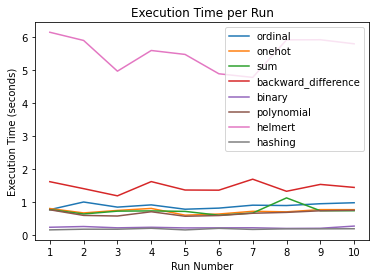

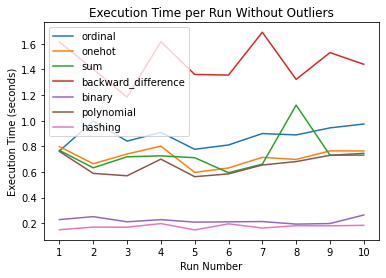

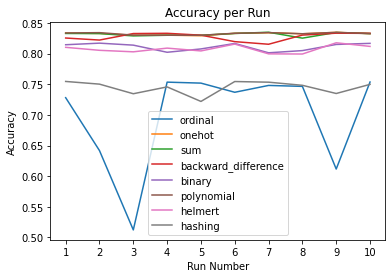

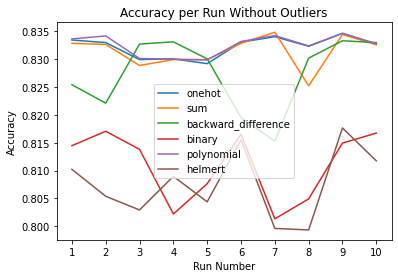

In [48]:
# run the experiment with the number of runs per encoding type
main_census(10)